<a href="https://colab.research.google.com/github/Tom-McDonald/studynotebooks/blob/master/Chapter_2_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 2 Exercises - End to End Machine Learning Project

---

* **1. Using this chapter's housing dataset, try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters such as `kernel='linear'` (with various values for the C hyperparameter) or `kernel='rbf'` (with various values for the C and `gamma` hyperparameters). Don't worry what these hyperparameters mean for now. How does the best SVR predictor perform?**

This first cell fetches the housing data and imports all the packages needed in this notebook. We'll skip all the visualisation since the exercises are based on the modelling aspect of the process.

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import scipy.stats as ss

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT+'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return(pd.read_csv(csv_path))

fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Next we split the data in training and test sets using `StratifiedShuffleSplit`, a stratified sampling method based on income categories in this case.

In [0]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

Next we prepare the data for modelling by imputing missing values, scaling the data, feature engineering and encoding the non numerical variable, then placing all of these steps in a preprocessing pipeline.

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1)                     # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop('ocean_proximity', axis=1)                            # separating the numerical features from the categorical 'ocean_proximity' feature
housing_cat = housing[['ocean_proximity']]


rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6                  #column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):                            # ()no *args or **kargs) creating a custom transformer class to add extra attributes
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),                           # pipeline for numerical preprocessing
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)                                                  # full pipeline including numerical and categorical preprocessing steps
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

Now the data is preprocessed as in the book, we can go ahead and tackle the exercise.

In [4]:
param_grid = [
    {'kernel':['rbf'], 'C':[10, 100], 'gamma':[0.001, 0.01]},                    # try these values of C and gamma for 'rbf' kernel
    {'kernel':['linear'], 'C':[10, 100]},                                        # try these values of C for 'linear' kernel
]

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=4, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1, verbose=True)
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_params_)

housing_predictions = grid_search.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
print("\nRMSE for the SVR model is £", svr_rmse)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.1min finished


{'C': 100, 'kernel': 'linear'}

RMSE for the SVR model is £ 71261.20809409635


This RMSE is worse than the Random Forest model used in the book, and actually it's also worse than the linear model tested. The `'linear'` kernel seems to perform better, as did higher values of C; even higher C values may improve the accuracy slightly.

* **2. Try replacing `GridSearchCV` with `RandomizedSearchCV`.**

In [5]:
param_dist = {'kernel':['rbf', 'linear'], 'C':ss.randint(10, 101), 
              'gamma':ss.uniform(0.001, 0.01)}

random_search = RandomizedSearchCV(svr, param_distributions=param_dist, 
                                   n_iter=6, cv=4, 
                                   scoring='neg_mean_squared_error', 
                                   return_train_score=True, n_jobs=-1, 
                                   verbose=True)
random_search.fit(housing_prepared, housing_labels)
print(random_search.best_params_)

housing_predictions = random_search.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
print("\nRMSE for the SVR model is £", svr_rmse)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.2min finished


{'C': 94, 'gamma': 0.0012143387535570528, 'kernel': 'linear'}

RMSE for the SVR model is £ 71324.84116336444


As discussed before, higher C values would likely result in better accuracy, but using the same values gives a good example of how `RandomizedSearchCV` tends to return hyperparameters which give the same, or better, performance than `GridSearchCV` in less time, as can be seen from the time elapsed.

The only difference in the solution given in the book is that instead of using `scipy.stats.randint` and `scipy.stats.uniform` for the random number selection distributions, it uses `scipy.stats.expon` and `scipy.stats.reciprocal`.

`expon` is used for `gamma` and is best used when you have some idea of what value the parameter should have, as most of the values fall between a relatively narrow range. Conversely, `reciprocal` is used here for C, and is best implemented when you have no idea of the hyperparameter scale, as all scales within the distribution are equally likely, as seen in the log plot. 

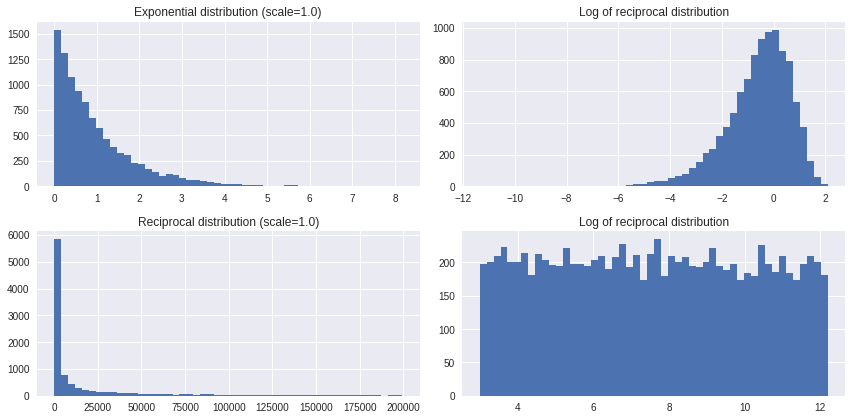

In [6]:
expon_distrib = ss.expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(222)
plt.title("Log of reciprocal distribution")
plt.hist(np.log(samples), bins=50)

reciprocal_distrib = ss.reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.subplot(223)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(224)
plt.title("Log of reciprocal distribution")
plt.hist(np.log(samples), bins=50)

plt.tight_layout()
plt.show()

* **3. Try adding a transformer in the preparation pipeline to select only the most important attributes.**

The first step is to find which features are most important; this can be done by training a Random Forest Regressor and returning the feature importances directly.

In [7]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]        # getting the attribute names, including the original and new ones from feature
cat_encoder = full_pipeline.named_transformers_["cat"]                           # engineering and one hot encoding
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = np.array(num_attribs + extra_attribs + cat_one_hot_attribs)

rf = RandomForestRegressor(n_estimators=10).fit(housing_prepared, housing_labels)
feat_imp = rf.feature_importances_

def sort_feat_importance(feat_imps, n):                                          # returns column indices of top n most important features
    top_n_feat_imps_idx = np.argsort(feat_imps)[::-1]
    top_n_feat_imps_idx = top_n_feat_imps_idx[:n]
    return(top_n_feat_imps_idx)

test_arr = sort_feat_importance(feat_imp, 5)                                     # testing the above function works correctly
print(test_arr)
print(attributes[test_arr])

[ 7 12  9  0  1]
['median_income' 'INLAND' 'pop_per_hhold' 'longitude' 'latitude']


Next we create a custom transformer to select these top features and insert the new transformer class into the pipeline. Finally, we do a check to assert that the transformer has worked, and the values in the `housing_prepared_top_features` array are identical to those returned if we select the top five most important features in the `housing_prepared` array manually.

In [0]:
class ImportantFeatureSelector(BaseEstimator, TransformerMixin):                 # creating a transformer class to select the top five features
    def __init__(self, feature_imps, n):
        self.feature_imps = feature_imps
        self.n = n
    def fit(self, X, y=None):
        self.feature_idx_ = sort_feat_importance(self.feature_imps, 
                                                 self.n)
        return self
    def transform(self, X, y=None):
        return X[:, self.feature_idx_]
        
top_feature_pipeline = Pipeline([                                                # creating a pipeline consisting of the original pipeline, plus the new transformer
        ('full_pipeline', full_pipeline),
        ('important_feat_select', ImportantFeatureSelector(feat_imp, 5)),    
    ])

housing_prepared_top_features = top_feature_pipeline.fit_transform(housing)

In [10]:
while True:
    try:
        np.testing.assert_array_equal(housing_prepared_top_features[0:3], 
                                  housing_prepared[0:3, test_arr])
        print('Feature selection successful, output values are correct')
        break
    except AssertionError:
            print('Unsuccessful transformation, output values incorrect')

Feature selection successful, output values are correct


* **4.Try creating a single pipeline that does the full data preparation plus the final prediction.**

Now we create a pipeline consisting of all the preprocessing steps, followed by a prediction using the best SVM model found during the very brief and non-exhaustive random search undertaken.

In [11]:
prep_and_predict = Pipeline([
    ('full_pipeline', full_pipeline),
    ('important_feat_select', ImportantFeatureSelector(feat_imp, 5)),
    ('prediction', SVR(**random_search.best_params_))
])

housing_prepared_pipeline = prep_and_predict.fit(housing, housing_labels)
mse_pipeline = mean_squared_error(housing_prepared_pipeline.predict(housing), 
                                  housing_labels)
rmse_pipeline = np.sqrt(mse_pipeline)
print('RMSE of predictions is £', rmse_pipeline)

RMSE of predictions is £ 76226.1495473514


* **5. Automatically explore some preparation options using GridSearchCV.**

Now we can try treating the feature selector as a hyperparameter, selecting the top 'n' features and comparing how model performance reacts to changing the number used in the modelling process.

In [12]:
param_grid = {
        'important_feat_select__n': [2,4,6],
        'prediction__C':[100],
        'prediction__kernel':['linear']
}

feature_search = GridSearchCV(prep_and_predict, param_grid, cv=4, verbose=True)
feature_search.fit(housing, housing_labels)
mse_feat_search = mean_squared_error(feature_search.predict(housing), 
                                  housing_labels)
rmse_feat_search = np.sqrt(mse_feat_search)
print('RMSE of predictions is £', rmse_feat_search)
print(feature_search.best_params_)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.6min finished


RMSE of predictions is £ 77472.41326994429
{'important_feat_select__n': 2, 'prediction__C': 100, 'prediction__kernel': 'linear'}


So we can see from the GridSearch that the best approach out of the options given was to keep only two features from the data, probably due to the fact that the first two features have much higher importances than the others. The book notes that the optimal solution is using 15 of the 16 features, but sampling 16 different possibilities with 5-fold cross validation would take about 20-30 minutes so to save time I've only chosen three values of n here, just to prove the concept.